# \[Old\] Baseline Model - Linear models with transformed data

The feature engineering and selection part is generally still relevant.

Dependencies:

- numpy
- pandas
- matplotlib
- seaborn (optional)
- sklearn
- scipy
- pyearth

### Importing libraries and reading files

In [1]:
# Import statements
# sklearn stuff are imported later
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth
%matplotlib inline

In [2]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset, null check ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   HH             45293 non-null  int64  
 3   LOW_IMPACT     45293 non-null  bool   
 4   MID_IMPACT     45293 non-null  bool   
 5   BIG_IMPACT     45293 non-null  bool   
 6   DIRECT_STRIKE  45293 non-null  bool   
 7   00LAT          45293 non-null  float32
 8   00LON          45293 non-null  float32
 9   00WIND         45293 non-null  int32  
 10  06LAT          45293 non-null  float32
 11  06LON          45293 non-null  float32
 12  06WIND         45293 non-null  int32  
 13  12LAT          45293 non-null  float32
 14  12LON          45293 non-null  float32
 15  12WIND         45293 non-null  int32  
 16  18LAT          45293 non-null  fl

In [3]:
# san-check: any nulls?
print("Null checking:")
print(dataset[dataset.isnull().any(axis=1)])

Null checking:
Empty DataFrame
Columns: [MM, DD, HH, LOW_IMPACT, MID_IMPACT, BIG_IMPACT, DIRECT_STRIKE, 00LAT, 00LON, 00WIND, 06LAT, 06LON, 06WIND, 12LAT, 12LON, 12WIND, 18LAT, 18LON, 18WIND, 24LAT, 24LON, 24WIND]
Index: []


In [4]:
dataset.describe()

,MM,DD,HH,00LAT,00LON,00WIND,06LAT,06LON,06WIND,12LAT,12LON,12WIND,18LAT,18LON,18WIND,24LAT,24LON,24WIND
count,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000,45293.000000
mean,8.283068,16.061025,8.918111,20.017653,132.009323,62.021063,19.506798,132.481476,62.087077,19.018631,132.967087,61.773122,18.551769,133.451675,61.072020,18.104473,133.910690,60.020864
std,2.310187,8.633509,6.698948,7.507561,19.457451,31.469743,7.243189,18.568924,31.423058,7.016464,17.948254,31.615497,6.824604,17.685791,31.978523,6.662520,17.910883,32.433757
min,1.000000,1.000000,0.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-179.899994,10.000000,1.300000,-180.000000,10.000000
25%,7.000000,9.000000,0.000000,14.500000,121.800003,35.000000,14.200000,122.400002,35.000000,13.900000,123.000000,35.000000,13.600000,123.500000,35.000000,13.200000,124.000000,35.000000
50%,8.000000,16.000000,6.000000,19.200001,131.300003,55.000000,18.799999,131.600006,55.000000,18.400000,132.000000,55.000000,18.000000,132.399994,55.000000,17.600000,132.800003,55.000000
75%,10.000000,23.000000,12.000000,24.700001,142.399994,80.000000,24.100000,142.699997,80.000000,23.500000,143.000000,80.000000,22.900000,143.399994,80.000000,22.299999,143.899994,80.000000
max,12.000000,31.000000,23.000000,55.500000,180.000000,185.000000,54.500000,180.000000,185.000000,53.500000,180.000000,185.000000,52.000000,180.000000,185.000000,50.500000,180.000000,185.000000


### General Dataset Preparation Tasks

In [5]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [6]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

In [7]:
print("================ Preparing Datasets ===============")

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

================ Preparing Datasets ===============
Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Testing and Evaluation Utilities

In [8]:
## Bookkeeping

# true positives given positive (recall)
low_impact_recall = dict()
mid_impact_recall = dict()
big_impact_recall = dict()
direct_strike_recall = dict()
# true positives among selected (precision)
low_impact_precision = dict()
mid_impact_precision = dict()
big_impact_precision = dict()
direct_strike_precision = dict()

# record best F1 scores for comparison
low_impact_f1 = dict()
mid_impact_f1 = dict()
big_impact_f1 = dict()
direct_strike_f1 = dict()
# thresholds corresponding to the best F1 scores
low_impact_threshold = dict()
mid_impact_threshold = dict()
big_impact_threshold = dict()
direct_strike_threshold = dict()

In [9]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [10]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

### Data Transformation and Feature Selection

Pipeline:

1. Polynomial features

   To account for interaction between variables (e.g. LON times WIND) and the correlated non-linearity, up to degree 3


2. (Failed) Select best features using ANOVA F-values

   ANOVA F values are computed and the best ones are selected, but they tend to pick up longitude-latitude interaction terms. Mutual Information scoring yielded similar results.
   
   
3. Principal component analysis (PCA)
   
   A number (values ranging from 10 to 750 are tested) of principal components are computed. Then the features contributing the most to each principal component are identified. Several picked up intensity values.
   
   N.B.: Kernel PCA and quadratic discriminant analysis (QDA) are possible alternatives.
   
   
4. Data transformation
   
   This is a two-fold step. The data are separately
   
       - Transformed using the results of PCA, so the >1000 input features are reduced to a smaller number. Then this set is fed to the models.
       
       - Transformed by filtering, i.e. only the best features as identified before are kept.
       

N.B.: Further feature selection is possible by means of a L1-regularized logit.

In [11]:
# imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [12]:
# Step 1: Generate polynomial features for train set
poly = PolynomialFeatures(degree=3, include_bias=False)
transformed_X = poly.fit_transform(train_X)

# for reference
transformed_X.shape

(36686, 1329)

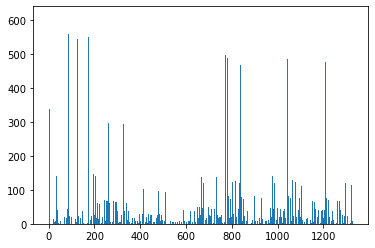

In [13]:
# Step 2: ANOVA F values: plot the scores for each of the polynomial terms
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(transformed_X, train_Y[:,3]) # one class at a time
fs_X = fs.transform(transformed_X)

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [14]:
# Step 2: ANOVA F-values: retrieve feature names from the best 30 features
fs = SelectKBest(score_func=f_classif, k=30)
fs.fit(transformed_X, train_Y[:,3]) # one class at a time
fs_X = fs.transform(transformed_X)

names = fs.get_feature_names_out()
original_names = poly.get_feature_names_out()
for i in range(len(names)):
    print(original_names[int(names[i][1:])])   

00LON^2
00LON 06LON
00LON 12LON
00LON 18LON
06LON^2
06LON 12LON
06LON 18LON
06LON 24LON
12LON^2
12LON 18LON
12LON 24LON
18LON^2
18LON 24LON
24LON^2
00LON^3
00LON^2 06LON
00LON^2 12LON
00LON^2 18LON
00LON^2 24LON
00LON 06LON^2
00LON 06LON 12LON
00LON 06LON 18LON
06LON^3
06LON^2 12LON
06LON^2 18LON
06LON^2 24LON
06LON 12LON^2
06LON 12LON 18LON
12LON^3
12LON^2 18LON


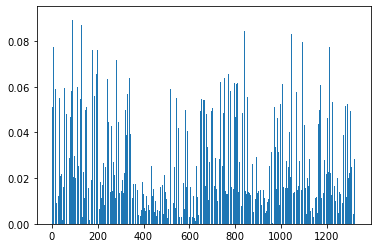

In [15]:
# Step 2: Mutual information: plot the scores for each of the polynomial terms
fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(transformed_X, train_Y[:,0]) # one class at a time
fs_X = fs.transform(transformed_X)

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [16]:
# Step 2: mutual information: retrieve feature names from the best 30 features
fs = SelectKBest(score_func=mutual_info_classif, k=30)
fs.fit(transformed_X, train_Y[:,0]) # one class at a time
fs_X = fs.transform(transformed_X)

names = fs.get_feature_names_out()
original_names = poly.get_feature_names_out()
for i in range(len(names)):
    print(original_names[int(names[i][1:])])   

00LON
00LON 06LON
00LON 12LON
00LON 18LON
00LON 24LON
06LON 12LON
06LON 18LON
06LON 24LON
MM^2 00LON
MM 00LON^2
MM 06LON^2
00LON^3
00LON^2 06LON
00LON^2 12LON
00LON^2 18LON
00LON^2 24LON
00LON 06LON^2
00LON 06LON 12LON
00LON 06LON 18LON
00LON 06LON 24LON
00LON 12LON^2
00LON 12LON 18LON
00LON 12LON 24LON
00LON 18LON^2
06LON^2 12LON
06LON^2 18LON
06LON^2 24LON
06LON 12LON^2
06LON 12LON 18LON
06LON 24LON^2


In [13]:
# Step 3: Perform PCA to obtain principal components
std_X = StandardScaler().fit(transformed_X)
standard_X = std_X.transform(transformed_X)
pca = PCA(n_components=450)
# pca = PCA(0.9875)
pca.fit(standard_X)

if (pca.n_components <= 50):
    print(pca.n_components_)
    print(pca.explained_variance_ratio_)

    # look at what terms PCA picked up
    n_pcs = pca.n_components_
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
    print(most_important)
    initial_feature_names = poly.get_feature_names_out()
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    print(most_important_names)

In [14]:
# Experiment: using the PCA-reduced-and-transformed data only

# finish transforming the train and dev sets
# train_X
pca_train_X = StandardScaler().fit_transform(poly.fit_transform(train_X))
pca_train_X = pca.transform(pca_train_X)
print(pca_train_X.shape)

# dev_X
transformed_dev_X = poly.fit_transform(dev_X)
standard_dev_X = StandardScaler().fit_transform(transformed_dev_X)
pca_dev_X = pca.transform(standard_dev_X)
print(pca_dev_X.shape)

(36686, 450)
(4077, 450)


In [19]:
# Standard procedure: only keep the terms selected by PCA
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = poly.get_feature_names_out()
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important = list(set(most_important)) # unique features only

transformed_X = poly.fit_transform(train_X)
filtered_train_X = transformed_X[:,most_important]
print(filtered_train_X.shape)

transformed_dev_X = poly.fit_transform(dev_X)
filtered_dev_X = transformed_dev_X[:,most_important]
print(filtered_dev_X.shape)

(36686, 222)
(4077, 222)


### Linear classification models built with transformed datasets

#### One-vs-Rest Logistic Classifier with PCA-transformed data
Data has undergone dimensionality reduction using PCA.

note: max_iter = 300 unless otherwise stated.

PCA has 150 components: F1-scores \[0.10 0.09 0.02 0.00\]

PCA has 300 components: F1-scores \[0.11 0.12 0.00 0.00\]

PCA has 450 components: F1-scores \[0.13 0.08 0.02 0.02\], alternative run optimized \[0.59 0.56 0.39 0.30\]

PCA has 600 components: F1-scores \[0.12 0.08 0.04 0.00\]

PCA has 600 components, max_iter = 600: F1-scores \[0.12 0.08 0.00 0.00\]

PCA has 750 components, max_iter = 600: F1-scores \[0.12 0.07 0.00 0.00\]

PCA has 750 components: F1-scores \[0.13 0.08 0.04 0.00\]

The results illustrate the inherent difficulty to predict this non-linear problem. It is also worth noting that the recall scores are typically pathetic/low. Beyond 750 components, it is surmised that the improvement brought by PCA becomes limited. Furthermore, it seems 450-600 components will be the sweet spot.

In [15]:
# PCA model, logistic
pca_clf = OneVsRestClassifier(LogisticRegression(
    max_iter=300,
    verbose=0   
), n_jobs=-1)

pca_clf = pca_clf.fit(pca_train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, pca_clf.predict(pca_train_X))))

# test model on dev set
preds = pca_clf.predict(pca_dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Training accuracy: 0.8858692689
Accuracy of classifier on dev set: 0.8834927643
              precision    recall  f1-score   support

           0       0.70      0.21      0.32       355
           1       0.66      0.15      0.24       296
           2       0.56      0.04      0.08       114
           3       0.00      0.00      0.00        72

   micro avg       0.68      0.15      0.24       837
   macro avg       0.48      0.10      0.16       837
weighted avg       0.61      0.15      0.23       837
 samples avg       0.02      0.02      0.02       837



Best Threshold=0.21031, F-Score=0.58029
Best Threshold=0.13668, F-Score=0.56468
Best Threshold=0.14325, F-Score=0.45455
Best Threshold=0.08772, F-Score=0.28682


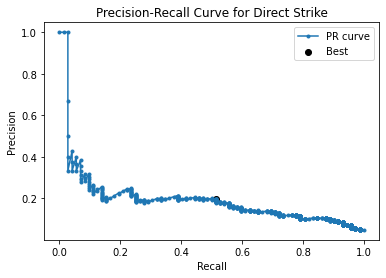

In [16]:
best_thresholds, best_f1_scores = optimize_thresholds(pca_clf, pca_dev_X, dev_Y)

In [17]:
preds = predictions_with_thresholds(pca_clf, best_thresholds, pca_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.47715   0.73521   0.57871       355
           1    0.44576   0.76351   0.56289       296
           2    0.37427   0.56140   0.44912       114
           3    0.19459   0.50000   0.28016        72

   micro avg    0.41631   0.70131   0.52247       837
   macro avg    0.37294   0.64003   0.46772       837
weighted avg    0.42773   0.70131   0.52978       837
 samples avg    0.06347   0.07957   0.06618       837



In [18]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_logit"] = recall[0]
mid_impact_recall["pca450_logit"] = recall[1]
big_impact_recall["pca450_logit"] = recall[2]
direct_strike_recall["pca450_logit"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_logit"] = precision[0]
mid_impact_precision["pca450_logit"] = precision[1]
big_impact_precision["pca450_logit"] = precision[2]
direct_strike_precision["pca450_logit"] = precision[3]

low_impact_f1["pca450_logit"] = best_f1_scores[0]
mid_impact_f1["pca450_logit"] = best_f1_scores[1]
big_impact_f1["pca450_logit"] = best_f1_scores[2]
direct_strike_f1["pca450_logit"] = best_f1_scores[3]

low_impact_threshold["pca450_logit"] = best_thresholds[0]
mid_impact_threshold["pca450_logit"] = best_thresholds[1]
big_impact_threshold["pca450_logit"] = best_thresholds[2]
direct_strike_threshold["pca450_logit"] = best_thresholds[3]

Recall: [0.73521127 0.76351351 0.56140351 0.5       ]
Precision: [0.47714808 0.44575937 0.37426901 0.19459459]


In [ ]:
save_sklearn_model_to_file(pca_clf, "pca450_logit")

#### One-vs-Rest Logistic Classifier with PCA-filtered data
Data is a filtered subset of the original polynomial features, filtering guided by PCA.

note: max_iter = 300 unless otherwise stated.
PCA has 600 components (150 unique features): F1-score \[0.01, 0.01, 0.00, 0.00\]

Visibly worse than the PCA-transformed one.

In [24]:
# standard model, logistic
filtered_clf = OneVsRestClassifier(LogisticRegression(
    max_iter=300,
    verbose=0   
), n_jobs=4)

filtered_clf = filtered_clf.fit(filtered_train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, filtered_clf.predict(filtered_train_X))))

# test model on dev set
preds = filtered_clf.predict(filtered_dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Training accuracy: 0.8824347162
Accuracy of classifier on dev set: 0.8815305372
              precision    recall  f1-score   support

           0       0.54      0.06      0.11       369
           1       0.34      0.04      0.08       260
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        88

   micro avg       0.44      0.04      0.07       819
   macro avg       0.22      0.03      0.05       819
weighted avg       0.35      0.04      0.07       819
 samples avg       0.01      0.00      0.00       819



#### Basic One-vs-Rest Logistic, all poly and Nystroem kernel
Basic logistic regression classifier that computes all polynomial features and then feeds them through a Nystroem kernel. The kernel approximation is done in light of the non-linear nature of the problem: even the degree 3 terms may remain linearly inseparable.

```
1 ---------xxx--------
  --------------------
  --------------------
0 xxxxxxxxx---xxxxxxxx

y axis: correct label
x axis: data values
```
Imagine a logistic trying to solve this (before polynomial terms are even found). The outcome was all-zero F1-scores.

kernel = 'poly', degree=3, n_components=500: F1-score \[0.39 0.29 0.03 0.02\], time taken <3 minutes

kernel = 'rbf', gamma=0.2, n_components=500: F1-score \[0.03 0.01 0.00 0.00 \], time taken <1 minute

kernel = 'sigmoid', gamma=0.2, n_components=500: F1-score \[0.21 0.21 0.08 0.00 \], time taken <3 minutes

kernel = PolynomialCountSketch, gamma=0.2, n_components=500: optimized F1-score \[0.56 0.53 0.36 0.29 \], time taken 3 minutes

no kernel used: F1-score \[0.36 0.28 0.02 0.00\]

In [19]:
# Bruteforce logistic with all poly features and kernel

basic_clf = OneVsRestClassifier(LogisticRegression(
    max_iter=300,
    verbose=0   
), n_jobs=-1)

pipe = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False), 
    StandardScaler(),
    #Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    PolynomialCountSketch(gamma=0.2, degree=3, n_components=500),
    basic_clf, verbose=True
)
print(pipe)

basic_clf = pipe.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf.predict(train_X))))

# test model on dev set
preds = basic_clf.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('polynomialcountsketch',
                 PolynomialCountSketch(degree=3, gamma=0.2, n_components=500)),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=300),
                                     n_jobs=-1))],
         verbose=True)
[Pipeline]  (step 1 of 4) Processing polynomialfeatures, total=   0.7s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.9s
[Pipeline]  (step 3 of 4) Processing polynomialcountsketch, total=   5.5s
[Pipeline]  (step 4 of 4) Processing onevsrestclassifier, total= 2.8min
Training accuracy: 0.8848879682
Accuracy of classifier on dev set: 0.8724552367
              precision    recall  f1-score   support

           0       0.61      0.34      0.43       355
           1       0.50      0.22      0.31  

Best Threshold=0.30464, F-Score=0.55581
Best Threshold=0.27141, F-Score=0.49383
Best Threshold=0.22894, F-Score=0.43123
Best Threshold=0.24356, F-Score=0.26190


/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


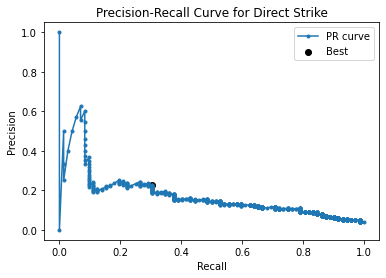

In [20]:
best_thresholds, best_f1_scores = optimize_thresholds(basic_clf, dev_X, dev_Y)

In [21]:
preds = predictions_with_thresholds(basic_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.47222   0.67042   0.55413       355
           1    0.41435   0.60473   0.49176       296
           2    0.37013   0.50000   0.42537       114
           3    0.22105   0.29167   0.25150        72

   micro avg    0.41772   0.59140   0.48961       837
   macro avg    0.36944   0.51670   0.43069       837
weighted avg    0.41625   0.59140   0.48850       837
 samples avg    0.05993   0.06733   0.05959       837



In [22]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["allpoly"] = recall[0]
mid_impact_recall["allpoly"] = recall[1]
big_impact_recall["allpoly"] = recall[2]
direct_strike_recall["allpoly"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["allpoly"] = precision[0]
mid_impact_precision["allpoly"] = precision[1]
big_impact_precision["allpoly"] = precision[2]
direct_strike_precision["allpoly"] = precision[3]

low_impact_f1["allpoly"] = best_f1_scores[0]
mid_impact_f1["allpoly"] = best_f1_scores[1]
big_impact_f1["allpoly"] = best_f1_scores[2]
direct_strike_f1["allpoly"] = best_f1_scores[3]

low_impact_threshold["allpoly"] = best_thresholds[0]
mid_impact_threshold["allpoly"] = best_thresholds[1]
big_impact_threshold["allpoly"] = best_thresholds[2]
direct_strike_threshold["allpoly"] = best_thresholds[3]

Recall: [0.67042254 0.60472973 0.5        0.29166667]
Precision: [0.47222222 0.41435185 0.37012987 0.22105263]


/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/userhome/cs/u3556490/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [ ]:
save_sklearn_model_to_file(basic_clf, "allpoly")

#### PCA transform -> Kernel -> OvR Logistic
Data reduced by PCA, passed though some kernel, and then one-vs-rest logits.

450 PCA components, max_iter = 750, kernel = PolynomialCountSketch(gamma=0.5, degree=3, n_components=500): F1-score \[0.35 0.28 0.20 0.11\], time needed ~6.5 min

450 PCA components, max_iter = 750, Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1): optimized F1-scores \[0.53 0.50 0.32 0.23\], time needed 2 minutes

In [23]:
pca_kernel_clf = OneVsRestClassifier(LogisticRegression(
    max_iter=500,
    verbose=0   
), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    #PolynomialCountSketch(gamma=0.5, degree=3, n_components=500),
    pca_kernel_clf, verbose=True
)
print(pipe)

pca_kernel_clf = pipe.fit(pca_train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, pca_kernel_clf.predict(pca_train_X))))

# test model on dev set
preds = pca_kernel_clf.predict(pca_dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=500),
                                     n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   1.1s
[Pipeline]  (step 3 of 3) Processing onevsrestclassifier, total= 1.1min
Training accuracy: 0.8824074579
Accuracy of classifier on dev set: 0.8812852588
              precision    recall  f1-score   support

           0       0.60      0.08      0.14       355
           1       0.58      0.07      0.13       296
           2       0.43      0.03      0.05       114
           3       0.00      0.00      0.00        72

   micro avg       0.56      0.06      0.11     

Best Threshold=0.17224, F-Score=0.53333
Best Threshold=0.15968, F-Score=0.53079
Best Threshold=0.09130, F-Score=0.35099
Best Threshold=0.06750, F-Score=0.20225


/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


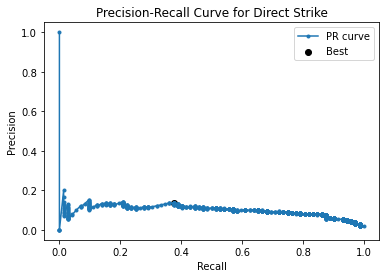

In [24]:
best_thresholds, best_f1_scores = optimize_thresholds(pca_kernel_clf, pca_dev_X, dev_Y)

In [25]:
preds = predictions_with_thresholds(pca_kernel_clf, best_thresholds, pca_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.45491   0.63944   0.53162       355
           1    0.46753   0.60811   0.52863       296
           2    0.27807   0.45614   0.34551       114
           3    0.13402   0.36111   0.19549        72

   micro avg    0.38340   0.57945   0.46147       837
   macro avg    0.33363   0.51620   0.40031       837
weighted avg    0.40769   0.57945   0.47630       837
 samples avg    0.05386   0.06479   0.05453       837



In [26]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_nystroem_logit"] = recall[0]
mid_impact_recall["pca450_nystroem_logit"] = recall[1]
big_impact_recall["pca450_nystroem_logit"] = recall[2]
direct_strike_recall["pca450_nystroem_logit"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_nystroem_logit"] = precision[0]
mid_impact_precision["pca450_nystroem_logit"] = precision[1]
big_impact_precision["pca450_nystroem_logit"] = precision[2]
direct_strike_precision["pca450_nystroem_logit"] = precision[3]

low_impact_f1["pca450_nystroem_logit"] = best_f1_scores[0]
mid_impact_f1["pca450_nystroem_logit"] = best_f1_scores[1]
big_impact_f1["pca450_nystroem_logit"] = best_f1_scores[2]
direct_strike_f1["pca450_nystroem_logit"] = best_f1_scores[3]

low_impact_threshold["pca450_nystroem_logit"] = best_thresholds[0]
mid_impact_threshold["pca450_nystroem_logit"] = best_thresholds[1]
big_impact_threshold["pca450_nystroem_logit"] = best_thresholds[2]
direct_strike_threshold["pca450_nystroem_logit"] = best_thresholds[3]

Recall: [0.63943662 0.60810811 0.45614035 0.36111111]
Precision: [0.45490982 0.46753247 0.27807487 0.13402062]


In [ ]:
save_sklearn_model_to_file(pca_kernel_clf, "pca450_nystroem_logit")

#### PCA transform -> kernel -> SVM
Data PCA-reduced, kernel-tricked, and then modelled with an SVM. This one unfortunately cannot compute probabilities; regressors will be needed.

450 components, Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1): F1-scores \[0.52 0.48 0.20 0.05\], time taken 1 minute

450 components, PolynomialCountSketch(gamma=0.2, degree=3, n_components=500): F1-scores \[0.16 0.10 0.04 0.03\], time taken 4 minutes 

In [29]:
from sklearn.svm import LinearSVC

pca_svm = OneVsRestClassifier(LinearSVC(dual=False), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    #Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    PolynomialCountSketch(gamma=0.2, degree=3, n_components=500),
    pca_svm, verbose=True
)
print(pipe)

pca_svm = pipe.fit(pca_train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, pca_svm.predict(pca_train_X))))

# test model on dev set
preds = pca_svm.predict(pca_dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialcountsketch',
                 PolynomialCountSketch(degree=3, gamma=0.2, n_components=500)),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LinearSVC(dual=False),
                                     n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.3s
[Pipeline]  (step 2 of 3) Processing polynomialcountsketch, total=   2.8s
[Pipeline]  (step 3 of 3) Processing onevsrestclassifier, total= 4.3min
Training accuracy: 0.4845172545
Accuracy of classifier on dev set: 0.4287466274
              precision    recall  f1-score   support

           0    0.09258   0.46761   0.15456       355
           1    0.08315   0.51351   0.14313       296
           2    0.03371   0.52632   0.06336       114
           3    0.02146   0.52778   0.04124        72

   micro avg    0.05800   0.49701   0.10388       837
   macro avg    0

In [30]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_nystroem_svc"] = recall[0]
mid_impact_recall["pca450_nystroem_svc"] = recall[1]
big_impact_recall["pca450_nystroem_svc"] = recall[2]
direct_strike_recall["pca450_nystroem_svc"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_nystroem_svc"] = precision[0]
mid_impact_precision["pca450_nystroem_svc"] = precision[1]
big_impact_precision["pca450_nystroem_svc"] = precision[2]
direct_strike_precision["pca450_nystroem_svc"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["pca450_nystroem_svc"] = best_f1_scores[0]
mid_impact_f1["pca450_nystroem_svc"] = best_f1_scores[1]
big_impact_f1["pca450_nystroem_svc"] = best_f1_scores[2]
direct_strike_f1["pca450_nystroem_svc"] = best_f1_scores[3]

Recall: [0.46760563 0.51351351 0.52631579 0.52777778]
Precision: [0.09258226 0.08315098 0.03370787 0.0214568 ]


In [ ]:
save_sklearn_model_to_file(pca_svm, "pca450_nystroem_svc")

#### Selecting a small number of features from models
No kernels were ever used at this stage. At C=0.0025,

SVM reported: ```['00WIND' 'MM 00WIND' 'MM 24LON' 'DD 00WIND' '00LON^2' 'MM^3' 'MM^2 DD'
 '00LAT^3' '00LAT^2 24WIND' '00LON^3' '00WIND^3']```
 
LogReg reported: ```['00WIND' '00LON^2' 'MM^3' '00LAT^3' '00LAT^2 06LAT' '00LAT^2 12LAT'
 '00LAT^2 24WIND' '00LON^3' '00LON^2 06LON']```
 
SGD reported (loss="modified_huber", penalty="l1", alpha=0.225): ```['12LON^2' '12LON 18LON' '18LON^2' '18LON 24LON' '24LON^2' '06LON 24LON^2'
 '12LON^2 24LON' '12LON 18LON^2' '12LON 18LON 24LON' '12LON 24LON^2'
 '18LON^3' '18LON^2 24LON' '18LON 24LON^2' '24LON^3']```

SGD (loss="log", penalty="l1", alpha=0.0375): ```['00LON^2' '00LON 06LON' '06LON^2' '06LON 12LON' '06LON 18LON' '12LON^2'
 '12LON 18LON' '18LON^2' '00LON^3' '00LON^2 06LON' '00LON^2 12LON'
 '00LON^2 18LON' '00LON^2 24LON' '00LON 06LON^2' '00LON 06LON 12LON'
 '00LON 06LON 18LON' '00LON 06LON 24LON']```
 
Compare this to PCA solving for 97.5% variance: ```['12LAT 12WIND 18LON', '12LAT 18LAT 24LAT', 'HH', 'DD', '06LON 24LON^2', 'MM', '00LAT 24WIND^2', '00WIND 12WIND 18WIND', '00LON', 'HH 00WIND 12WIND', 'DD 00LON 24WIND', '18LON', 'DD 06WIND 12WIND', 'DD HH 00LON', 'HH 00LAT^2', 'DD 00LAT^2']```

And PCA for 98.75% variance: ```['12LAT 12WIND 18LON', '12LAT 18LAT 24LAT', 'HH', 'DD', '06LON 24LON^2', 'MM', '00LAT 24WIND^2', '00WIND 12WIND 18WIND', '00LON', 'HH 00WIND 12WIND', 'DD 00LON 24WIND', '18LON', 'DD 06WIND 12WIND', 'DD HH 00LON', 'HH 00LAT^2', 'DD 00LAT^2', '00LON 06LON 24LON', 'DD HH 00LAT', 'DD^2 HH', 'MM^2 12WIND', 'MM 24WIND^2', 'MM^2 24LAT', '24LON', '12LON 24LON']```

we can count the most common 10 features among what the four linear models reported:

Minimal impact: ```[('00LON^2', 6), ('00LON^3', 4), ('06LON^2', 4), ('12LON^2', 4), ('18LON^2', 4), ('24LON^2', 3), ('00WIND', 2), ('MM^3', 2), ('00LAT^3', 2), ('00LAT^2 24WIND', 2)]```

Limited impact: ```[('00LON^2', 3), ('00WIND', 2), ('MM^3', 2), ('00LAT^3', 2), ('00LON 06LON', 2), ('06LON^2', 2), ('00LON^3', 2), ('MM 00LAT', 1), ('MM 00WIND', 1), ('MM 24LON', 1)]```

Substantial impact: ```[('00LON^2', 2), ('00WIND', 1), ('06WIND', 1), ('MM^3', 1), ('MM^2 DD', 1), ('24LAT^3', 1), ('06LON^2', 1)]```

Direct strike: ```[('00LON^2', 3), ('06LON^2', 2), ('00WIND', 1), ('MM^3', 1), ('24LON', 1), ('MM 24LON', 1), ('00LON 24LON', 1), ('06LON 12LON', 1), ('06LON 18LON', 1), ('06LON 24LON', 1)]```

In [31]:
names_lists = list()
for i in range(4):
    names_lists.append(list())

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

pipe = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, penalty="l1", C=0.0025), 
    verbose=True
)
poly = PolynomialFeatures(degree=3, include_bias=False).fit(train_X)
for i in range(4):
    lsvc = pipe.fit(poly.transform(train_X), train_Y[:,i])
    selection = SelectFromModel(lsvc.named_steps['linearsvc'], prefit=True)
    names = selection.get_feature_names_out(poly.get_feature_names_out())
    if i == 3:
        print(names)
    names_lists[i].append(names)

In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", C=0.0025, max_iter=500, solver='saga', n_jobs=-1), 
    verbose=True
)
poly = PolynomialFeatures(degree=3, include_bias=False).fit(train_X)
for i in range(4):
    lsvc = pipe.fit(poly.transform(train_X), train_Y[:,i])
    selection = SelectFromModel(lsvc.named_steps['logisticregression'], prefit=True)
    names = selection.get_feature_names_out(poly.get_feature_names_out())
    if i == 3:
        print(names)
    names_lists[i].append(names)

In [ ]:
from sklearn.linear_model import SGDClassifier

pipe = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss="log", penalty="l1", alpha=0.035, early_stopping=True, n_jobs=-1), # alpha selection needs more work
    verbose=True
)
poly = PolynomialFeatures(degree=3, include_bias=False).fit(train_X)
for i in range(4):
    lsvc = pipe.fit(poly.transform(train_X), train_Y[:,i])
    selection = SelectFromModel(lsvc.named_steps['sgdclassifier'], prefit=True)
    names = selection.get_feature_names_out(poly.get_feature_names_out())
    if i == 3:
        print(names)
    names_lists[i].append(names)

In [ ]:
from collections import Counter

l1_selected_features = list()
for i in range(4):
    flattened_list = [elem for sublist in names_lists[i] for elem in sublist]
    counter = Counter(flattened_list)
    commonest = counter.most_common()[:10] # 10 most common features
    print(i, commonest)
    
    l1_selected_features.append(commonest)

### Regressional models built with PCA-transformed data

In [17]:
# new utility functions
from scipy.special import expit

def regression_predict(regr, datasetX, method='sigmoid'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='sigmoid'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='sigmoid'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

#### Linear regression, no kernel

In [33]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(pca_train_X, train_Y)

Best Threshold=0.56132, F-Score=0.49220
Best Threshold=0.54295, F-Score=0.47579
Best Threshold=0.53127, F-Score=0.33824
Best Threshold=0.51749, F-Score=0.17439


/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


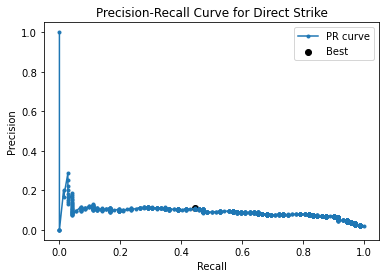

In [34]:
best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, pca_dev_X, dev_Y, 'sigmoid')

In [41]:
preds = regression_label(linear_regr, pca_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.38811   0.62535   0.47896       355
           1    0.34940   0.68581   0.46294       296
           2    0.28205   0.38596   0.32593       114
           3    0.10569   0.36111   0.16352        72

   micro avg    0.31833   0.59140   0.41388       837
   macro avg    0.28131   0.51456   0.35784       837
weighted avg    0.33568   0.59140   0.42532       837
 samples avg    0.05400   0.06659   0.05506       837



In [42]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_linear_regr"] = recall[0]
mid_impact_recall["pca450_linear_regr"] = recall[1]
big_impact_recall["pca450_linear_regr"] = recall[2]
direct_strike_recall["pca450_linear_regr"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_linear_regr"] = precision[0]
mid_impact_precision["pca450_linear_regr"] = precision[1]
big_impact_precision["pca450_linear_regr"] = precision[2]
direct_strike_precision["pca450_linear_regr"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["pca450_linear_regr"] = best_f1_scores[0]
mid_impact_f1["pca450_linear_regr"] = best_f1_scores[1]
big_impact_f1["pca450_linear_regr"] = best_f1_scores[2]
direct_strike_f1["pca450_linear_regr"] = best_f1_scores[3]

Recall: [0.62535211 0.68581081 0.38596491 0.36111111]
Precision: [0.38811189 0.34939759 0.28205128 0.10569106]


#### Linear regression, poly kernel

In [36]:
regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    regr, verbose=True
)
print(pipe)

poly_regr = pipe.fit(pca_train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearRegression(),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   1.1s
[Pipeline]  (step 3 of 3) Processing multioutputregressor, total=   2.3s


Best Threshold=0.55671, F-Score=0.49530
Best Threshold=0.54630, F-Score=0.46993
Best Threshold=0.53137, F-Score=0.33452
Best Threshold=0.51841, F-Score=0.16156


/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


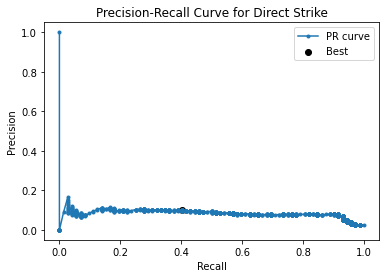

In [37]:
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_regr, pca_dev_X, dev_Y, 'sigmoid')

In [43]:
preds = regression_label(poly_regr, pca_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.39268   0.66479   0.49372       355
           1    0.34942   0.70946   0.46823       296
           2    0.27711   0.40351   0.32857       114
           3    0.09790   0.38889   0.15642        72

   micro avg    0.31439   0.62127   0.41750       837
   macro avg    0.27928   0.54166   0.36174       837
weighted avg    0.33628   0.62127   0.43320       837
 samples avg    0.05470   0.07033   0.05708       837



In [44]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_nystroem_linreg"] = recall[0]
mid_impact_recall["pca450_nystroem_linreg"] = recall[1]
big_impact_recall["pca450_nystroem_linreg"] = recall[2]
direct_strike_recall["pca450_nystroem_linreg"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_nystroem_linreg"] = precision[0]
mid_impact_precision["pca450_nystroem_linreg"] = precision[1]
big_impact_precision["pca450_nystroem_linreg"] = precision[2]
direct_strike_precision["pca450_nystroem_linreg"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["pca450_nystroem_linreg"] = best_f1_scores[0]
mid_impact_f1["pca450_nystroem_linreg"] = best_f1_scores[1]
big_impact_f1["pca450_nystroem_linreg"] = best_f1_scores[2]
direct_strike_f1["pca450_nystroem_linreg"] = best_f1_scores[3]

Recall: [0.66478873 0.70945946 0.40350877 0.38888889]
Precision: [0.39267887 0.34941764 0.27710843 0.0979021 ]


#### All Polynomial Features, no PCA

no kernel: F-Score = \[0.49153 0.43750 0.26506 0.18297 \]

yes kernel: F-Score = \[0.53194 0.48214 0.31746 0.23041 \]

In [45]:
regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)

pipe = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    regr, verbose=True
)
print(pipe)

basic_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearRegression(),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline]  (step 1 of 4) Processing polynomialfeatures, total=   0.7s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.9s
[Pipeline] .......... (step 3 of 4) Processing nystroem, total=   1.5s
[Pipeline]  (step 4 of 4) Processing multioutputregressor, total=   2.2s


Best Threshold=0.56011, F-Score=0.50875
Best Threshold=0.55254, F-Score=0.48561
Best Threshold=0.53735, F-Score=0.35652
Best Threshold=0.52038, F-Score=0.19608


/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


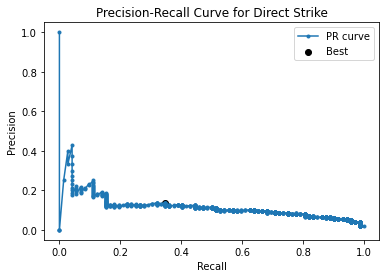

In [46]:
best_thresholds, best_f1_scores = regressor_find_thresholds(basic_regr, dev_X, dev_Y, 'sigmoid')

In [47]:
preds = regression_label(basic_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.40000   0.69296   0.50722       355
           1    0.38446   0.65203   0.48371       296
           2    0.34783   0.35088   0.34934       114
           3    0.13187   0.33333   0.18898        72

   micro avg    0.35573   0.60096   0.44691       837
   macro avg    0.31604   0.50730   0.38231       837
weighted avg    0.36433   0.60096   0.45003       837
 samples avg    0.06179   0.06962   0.06057       837



In [48]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["allpoly_nystroem_linreg"] = recall[0]
mid_impact_recall["allpoly_nystroem_linreg"] = recall[1]
big_impact_recall["allpoly_nystroem_linreg"] = recall[2]
direct_strike_recall["allpoly_nystroem_linreg"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["allpoly_nystroem_linreg"] = precision[0]
mid_impact_precision["allpoly_nystroem_linreg"] = precision[1]
big_impact_precision["allpoly_nystroem_linreg"] = precision[2]
direct_strike_precision["allpoly_nystroem_linreg"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["allpoly_nystroem_linreg"] = best_f1_scores[0]
mid_impact_f1["allpoly_nystroem_linreg"] = best_f1_scores[1]
big_impact_f1["allpoly_nystroem_linreg"] = best_f1_scores[2]
direct_strike_f1["allpoly_nystroem_linreg"] = best_f1_scores[3]

Recall: [0.69295775 0.65202703 0.35087719 0.33333333]
Precision: [0.4        0.38446215 0.34782609 0.13186813]


#### SVM Regressor, PCA transformed data with kernel

In [49]:
from sklearn.svm import LinearSVR

regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    regr, verbose=True
)
print(pipe)

svm_regr = pipe.fit(pca_train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   1.1s
[Pipeline]  (step 3 of 3) Processing multioutputregressor, total=  12.4s


Best Threshold=0.55479, F-Score=0.49794
Best Threshold=0.54436, F-Score=0.48026
Best Threshold=0.52842, F-Score=0.32716
Best Threshold=0.51706, F-Score=0.16377


/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


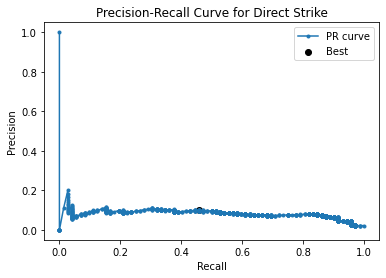

In [50]:
best_thresholds, best_f1_scores = regressor_find_thresholds(svm_regr, pca_dev_X, dev_Y, 'sigmoid')

In [51]:
preds = regression_label(svm_regr, pca_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.39123   0.67887   0.49640       355
           1    0.35447   0.73649   0.47859       296
           2    0.24880   0.45614   0.32198       114
           3    0.09697   0.44444   0.15920        72

   micro avg    0.30678   0.64875   0.41657       837
   macro avg    0.27287   0.57899   0.36404       837
weighted avg    0.33352   0.64875   0.43734       837
 samples avg    0.05639   0.07340   0.05896       837



In [52]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["pca450_nystroem_svr"] = recall[0]
mid_impact_recall["pca450_nystroem_svr"] = recall[1]
big_impact_recall["pca450_nystroem_svr"] = recall[2]
direct_strike_recall["pca450_nystroem_svr"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["pca450_nystroem_svr"] = precision[0]
mid_impact_precision["pca450_nystroem_svr"] = precision[1]
big_impact_precision["pca450_nystroem_svr"] = precision[2]
direct_strike_precision["pca450_nystroem_svr"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["pca450_nystroem_svr"] = best_f1_scores[0]
mid_impact_f1["pca450_nystroem_svr"] = best_f1_scores[1]
big_impact_f1["pca450_nystroem_svr"] = best_f1_scores[2]
direct_strike_f1["pca450_nystroem_svr"] = best_f1_scores[3]

Recall: [0.67887324 0.73648649 0.45614035 0.44444444]
Precision: [0.39123377 0.35447154 0.24880383 0.0969697 ]


#### K-Neighbours Regressor

No PCA, weights='distance', n_neighbors=40: \[0.61 0.59 0.48 0.41 \]

With PCA, same setting: \[0.52 0.48 0.27 0.19\]

In [53]:
from sklearn.neighbors import KNeighborsRegressor

regr = MultiOutputRegressor(KNeighborsRegressor(), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    # Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    regr, verbose=True
)
print(pipe)

knr_regr = pipe.fit(pca_train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=KNeighborsRegressor(),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.3s
[Pipeline]  (step 2 of 2) Processing multioutputregressor, total=   2.4s


Best Threshold=0.59869, F-Score=0.45017
Best Threshold=0.59869, F-Score=0.42468
Best Threshold=0.59869, F-Score=0.22936
Best Threshold=0.54983, F-Score=0.16949


/tmp/.u3556490/ipykernel_13807/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


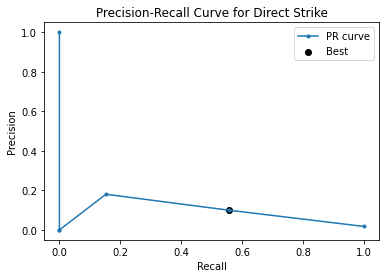

In [54]:
best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, pca_dev_X, dev_Y, 'sigmoid')

In [55]:
preds = regression_label(knr_regr, pca_dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.52792   0.29296   0.37681       355
           1    0.48148   0.21959   0.30162       296
           2    0.40000   0.05263   0.09302       114
           3    0.18033   0.15278   0.16541        72

   micro avg    0.45588   0.22222   0.29880       837
   macro avg    0.39743   0.17949   0.23422       837
weighted avg    0.46417   0.22222   0.29339       837
 samples avg    0.03285   0.02686   0.02755       837



#### SGDRegressor

In [56]:
from sklearn.linear_model import SGDRegressor

regr = MultiOutputRegressor(SGDRegressor(early_stopping=True), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    regr, verbose=True
)
print(pipe)

sgd_regr = pipe.fit(pca_train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=SGDRegressor(early_stopping=True),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.3s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   1.1s
[Pipeline]  (step 3 of 3) Processing multioutputregressor, total=   1.0s


Best Threshold=0.00000, F-Score=0.17686
Best Threshold=0.00000, F-Score=0.13538
Best Threshold=0.00000, F-Score=0.05440
Best Threshold=1.00000, F-Score=0.04460


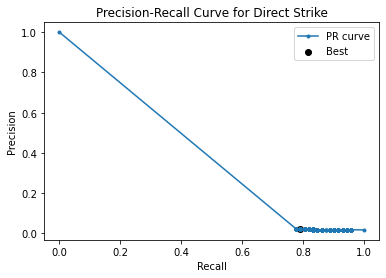

In [57]:
best_thresholds, best_f1_scores = regressor_find_thresholds(sgd_regr, pca_dev_X, dev_Y, 'sigmoid')

### Regression splines
#### everything as input

In [15]:
from sklearn.multioutput import MultiOutputRegressor

earth_regr = MultiOutputRegressor(Earth(max_degree=5, max_terms=600), n_jobs=-1)
earth_regr = earth_regr.fit(train_X, train_Y)

/tmp/.u3556490/ipykernel_21606/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_21606/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_21606/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_21606/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.55389, F-Score=0.45582
Best Threshold=0.55196, F-Score=0.48139
Best Threshold=0.53158, F-Score=0.27004
Best Threshold=0.51804, F-Score=0.15063


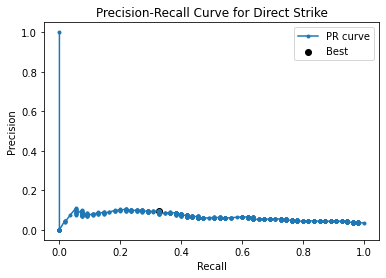

In [18]:
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [61]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.36483   0.70704   0.48130       355
           1    0.41597   0.66892   0.51295       296
           2    0.31858   0.31579   0.31718       114
           3    0.12245   0.41667   0.18927        72

   micro avg    0.33837   0.61529   0.43663       837
   macro avg    0.30546   0.52710   0.37518       837
weighted avg    0.35576   0.61529   0.44502       837
 samples avg    0.06255   0.07291   0.06175       837



In [62]:
# bookkeeping
recall = recall_score(dev_Y, preds, average=None, zero_division=0)
print("Recall:", recall)
low_impact_recall["mars5_600"] = recall[0]
mid_impact_recall["mars5_600"] = recall[1]
big_impact_recall["mars5_600"] = recall[2]
direct_strike_recall["mars5_600"] = recall[3]

precision = precision_score(dev_Y, preds, average=None, zero_division=0)
print("Precision:", precision)
low_impact_precision["mars5_600"] = precision[0]
mid_impact_precision["mars5_600"] = precision[1]
big_impact_precision["mars5_600"] = precision[2]
direct_strike_precision["mars5_600"] = precision[3]

best_f1_scores = f1_score(dev_Y, preds, average=None, zero_division=0)
low_impact_f1["mars5_600"] = best_f1_scores[0]
mid_impact_f1["mars5_600"] = best_f1_scores[1]
big_impact_f1["mars5_600"] = best_f1_scores[2]
direct_strike_f1["mars5_600"] = best_f1_scores[3]

Recall: [0.70704225 0.66891892 0.31578947 0.41666667]
Precision: [0.36482558 0.41596639 0.31858407 0.12244898]


#### with kernel

In [19]:
earth_kernel_regr = MultiOutputRegressor(Earth(max_degree=4, max_terms=400), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3, n_components=500, n_jobs=-1),
    earth_kernel_regr, verbose=True
)
print(pipe)

earth_kernel_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem',
                 Nystroem(degree=3, kernel='poly', n_components=500,
                          n_jobs=-1)),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=Earth(max_degree=4,
                                                      max_terms=400),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   1.0s


KeyboardInterrupt: 

In [ ]:
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [ ]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))